In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 

import sys
sys.path.append(f'/home/beans/bespoke')
from constants import *

import matplotlib.pyplot as plt
from viz_utils import draw_wps
from loaders import *
from constants import *
from imports import *
from models import *
from viz_utils import *
torch.__version__

/home/beans/bespoke/constants.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  propref_aux_target['ixx'] = list(range(len(propref_aux_target))) # dumb self ix so can grab sigmoid from within this smaller df


'1.13.1'

In [2]:
%%time
loader = TrnLoader(bs=6, n_batches=20, bptt=1) # 1200

dd [0 0]


/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:316: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


promoting backup chunk
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
backup chunk not yet ready
dd [0 1]
backup chunk not yet ready
[0 1]
dd [0 0]
Got first chunk
queueing batch
CPU times: user 946 ms, sys: 52

In [3]:
controller_props = ["should_stop", "backup_chunk_ready"]
controller_shm = shared_memory.SharedMemory(name="controller_shm")
controller = np.ndarray((len(controller_props),), dtype='uint8', buffer=controller_shm.buf)

In [7]:
controller[1] = 0

In [ ]:
%%time
batch = loader.get_batch()
img, aux, wps, (to_pred_mask, is_first_in_seq) = batch

In [ ]:
loader.queued_batches

In [23]:
from norm import *
b_ix = 0
_img = (denorm_img(img[b_ix][0].permute(1,2,0).detach().cpu().numpy()) * 255).astype('uint8')
_img.shape

(360, 1440, 4)

In [5]:
m = EffNet().to(device) 
model_stem = "12.30_avg"
m.load_state_dict(torch.load(f"{BESPOKE_ROOT}/models/m_{model_stem}.torch"), strict=False)
m.set_for_viz() # comment out hooks in model to test this path
m.eval()
sum([torch.numel(p) for p in m.parameters()]) / 1000

18303.055

In [6]:
actgrad = get_actgrad(m, img, aux_model, aux_calib, actgrad_target='traj')
actgrad.shape

(360, 1440, 1)

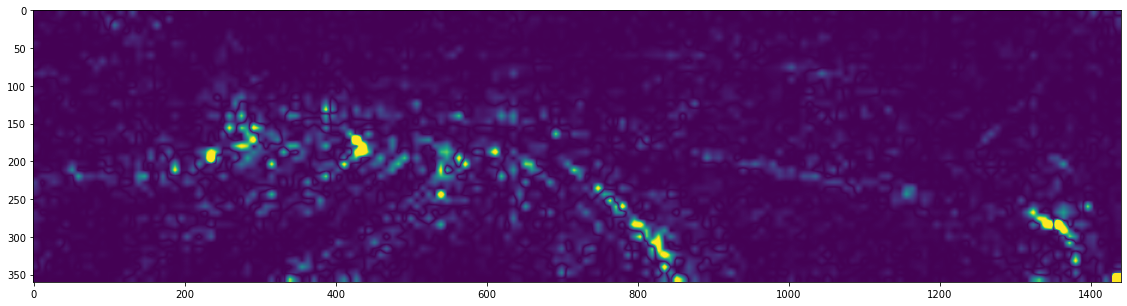

In [7]:
plt.figure(figsize=(20,5))
plt.imshow(actgrad.astype(np.float32))

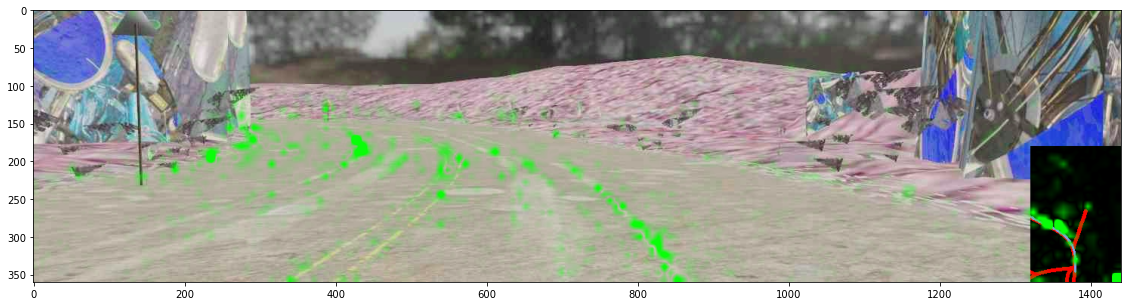

In [8]:
img_actgrad = combine_img_actgrad(_img[:,:,:3], actgrad)
plt.figure(figsize=(20,5))
plt.imshow(img_actgrad)

In [9]:
m

EffNet(
  (backbone): Sequential(
    (0): Conv2d(4, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
    (3): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    

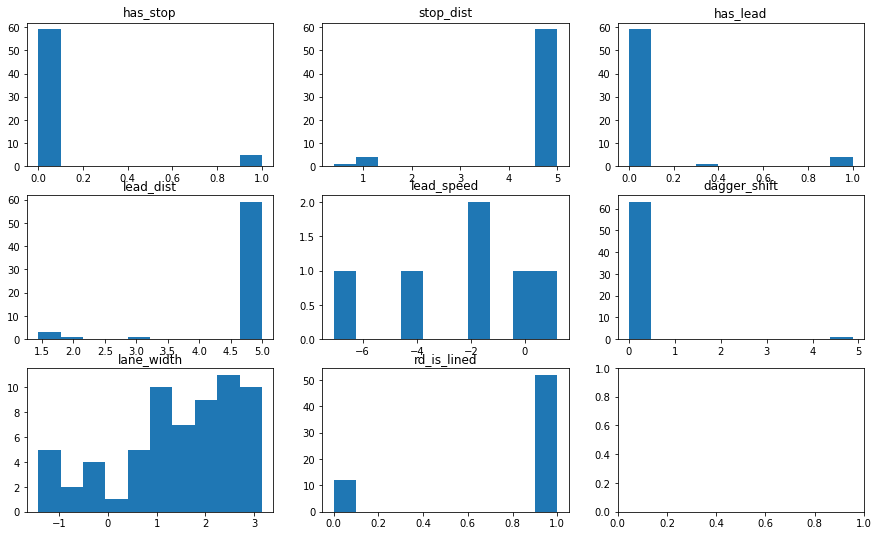

In [29]:
aux_np = na(aux.detach().cpu().numpy(), AUX_PROPS)
plot_aux(aux_np, AUX_TARGET_PROPS)

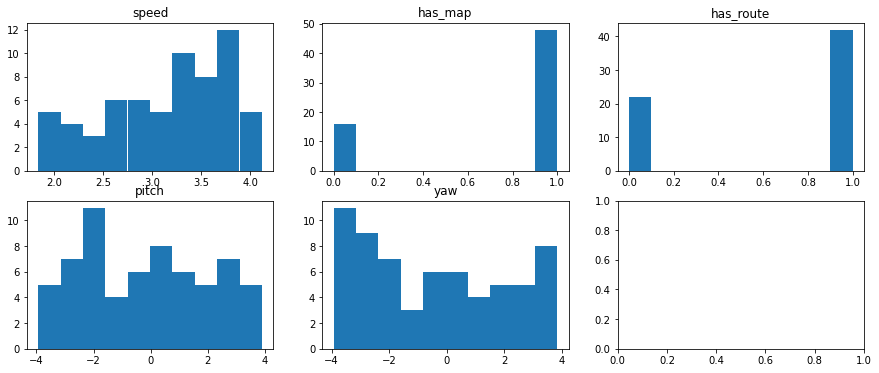

In [30]:
plot_aux(aux_np, AUX_MODEL_PROPS)

In [31]:
wp_angles, wp_headings, wp_curvatures, wp_rolls, wp_zs = np.split(wps.detach().cpu().numpy(), 5, -1)
wp_angles.shape, wp_headings.shape, wp_curvatures.shape, wp_rolls.shape, wp_zs.shape

((64, 1, 30), (64, 1, 30), (64, 1, 30), (64, 1, 30), (64, 1, 30))

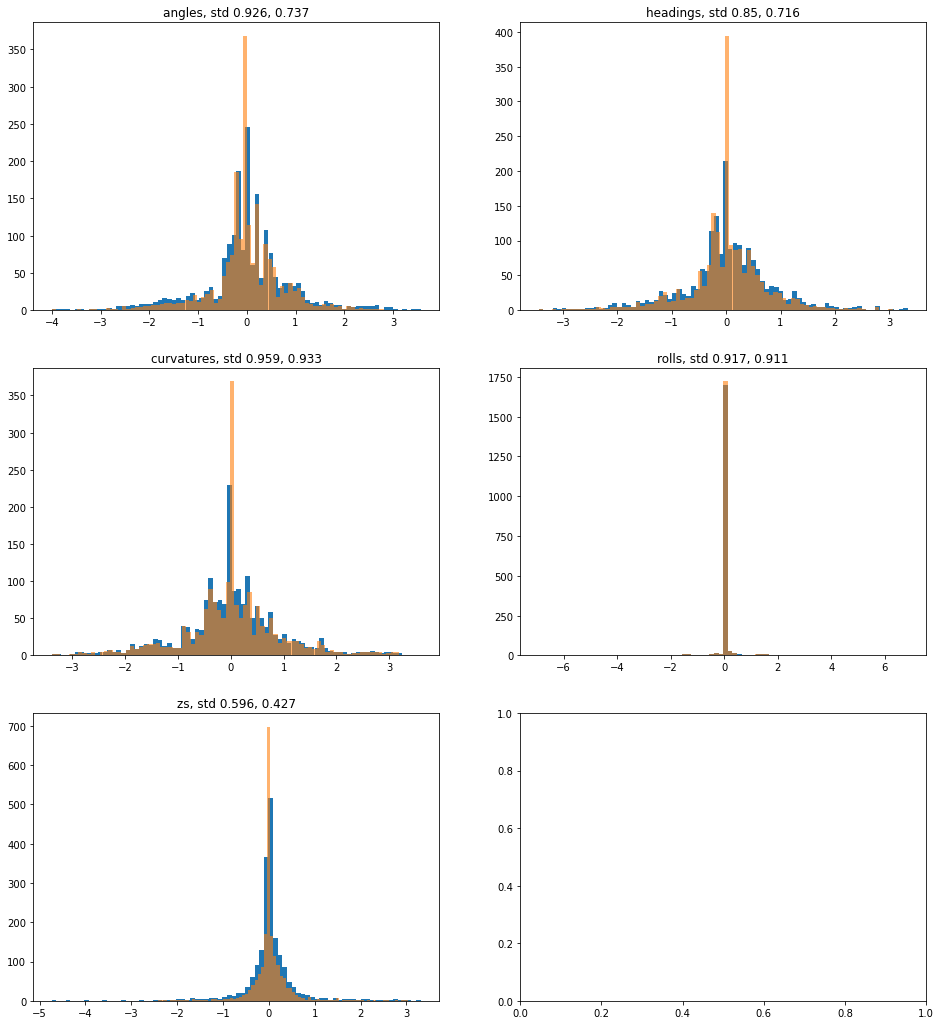

In [32]:
plot_wps([wp_angles, wp_headings, wp_curvatures, wp_rolls, wp_zs], to_pred_mask.detach().cpu().numpy())

In [33]:
to_pred_mask.sum() / to_pred_mask.numel()

tensor(0.9005, device='cuda:0')

In [2]:
from models import *
m = EffNet().to(device) 
sum([torch.numel(p) for p in m.parameters()]) / 1000

INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b4_ra2_320-7eb33cd5.pth)
INFO:timm.models.helpers:Converted input conv conv_stem pretrained weights from 3 to 6 channel(s)


18303.919

In [3]:
# randoms
img = torch.randn((1,1, N_CHANNELS, IMG_HEIGHT, IMG_WIDTH)).to(device).half()
aux_model = torch.randn((1,1, N_AUX_MODEL_IN)).to(device).half()
aux_calib = torch.randn((1,1, N_AUX_CALIB_IN)).to(device).half()

In [7]:
%%time
with torch.no_grad():
    with torch.cuda.amp.autocast(): 
        wps_preds, aux_preds, obs_net_out  = m(img, aux_model, aux_calib)

CPU times: user 25.3 ms, sys: 518 µs, total: 25.8 ms
Wall time: 24.9 ms


In [8]:
m.load_trt_backbone()

In [20]:
# randoms
img = torch.randn((1,1, N_CHANNELS, IMG_HEIGHT, IMG_WIDTH)).to(device)
aux_model = torch.randn((1,1, N_AUX_MODEL_IN)).to(device)
aux_calib = torch.randn((1,1, N_AUX_CALIB_IN)).to(device)

In [21]:
%%time
with torch.no_grad():
    wps_preds, aux_preds, obs_net_out  = m(img, aux_model, aux_calib)

CPU times: user 2.83 ms, sys: 1.02 ms, total: 3.85 ms
Wall time: 2.63 ms


In [8]:
import subprocess

In [9]:
# Load up membank from ssd to shm
subprocess.run("cp -R /media/beans/beans_data/blender_membank /dev/shm/blender_membank", shell=True)

CompletedProcess(args='cp -R /media/beans/beans_data/blender_membank /dev/shm/blender_membank', returncode=0)

In [ ]:
# save membank to ssd
subprocess.run("cp -R /dev/shm/blender_membank /media/beans/beans_data/blender_membank", shell=True)